In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestRegressor

## Data Preprocessing

In [2]:
df = pd.read_csv('../data/voter_turnout_merged_all_states.csv')
print("shape: ",df.shape)
df.head()

shape:  (1492, 69)


,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,total_voters_college,total_voters_no_college,voted_voters_college,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state
0,Oakland,2020_11_03,2020,General,30600.0,61476.0,37174.0,8628.0,83122.0,23041.0,...,80668.0,27989.0,71356.0,22543.0,88.456389,80.542356,47.829424,331652,172221.0,CA
1,Oakland,2018_11_06,2018,General,30600.0,61476.0,37174.0,8628.0,83122.0,14972.0,...,80668.0,27989.0,59248.0,17372.0,73.446720,62.067241,48.224196,331652,130249.0,CA
2,Oakland,2016_11_08,2016,General,30600.0,61476.0,37174.0,8628.0,83122.0,16057.0,...,80668.0,27989.0,60766.0,18951.0,75.328507,67.708743,46.819512,331652,135633.0,CA
3,Oakland,2014_11_04,2014,General,30600.0,61476.0,37174.0,8628.0,83122.0,8145.0,...,80668.0,27989.0,38216.0,10811.0,47.374424,38.625889,51.034918,331652,75153.0,CA
4,San Leandro,2020_11_03,2020,General,12705.0,5596.0,16028.0,2429.0,17780.0,9229.0,...,19051.0,10653.0,16014.0,8674.0,84.058580,81.423073,49.752550,70359,41879.0,CA


In [3]:
df.Residence_Addresses_City.nunique()

213

In [4]:

#replace all NAN for voted_voters and total_voters counts  with 0

for col in ['voted_voters_asian', 'voted_voters_black', 'voted_voters_hispanic', 'voted_voters_others', 'voted_voters_white']:
    df[col] = df[col].fillna(0)
#double check to make sure the sum adds up
print(sum(df['voted_voters'] != df['voted_voters_asian'] + 
          df['voted_voters_black']+df['voted_voters_hispanic'] + 
          df['voted_voters_others'] + df['voted_voters_white']))

for col in ['total_voters_asian', 'total_voters_black', 'total_voters_hispanic', 'total_voters_others', 'total_voters_white']:
    df[col] = df[col].fillna(0)
        
# voter_population is calculated from census data for people over age 20
# calculate new total_voters columns that should be used instead.
df['total_voters'] = df['total_voters_asian'] + df['total_voters_black']+df['total_voters_hispanic'] + df['total_voters_others'] + df['total_voters_white']
print(sum(df['total_voters'] !=  df['voter_population']))
print(df.shape)
df = df.drop(columns = ['voter_population'])
print(df.shape)

0
1492
(1492, 70)
(1492, 69)


In [5]:
print(df[df["elec_type"] == 'General'].elec_date.unique())
print(df[df["elec_type"] != 'General'].elec_date.unique())

['2020_11_03' '2018_11_06' '2016_11_08' '2014_11_04']
['2019_11_05' '2015_11_03' '2013_11_05' '2011_11_08' '2017_11_07'
 '2019_03_05' '2017_03_07' '2017_04_11' '2017_02_28' '2015_04_14'
 '2021_11_02' '2021_06_08' '2019_06_04' '2021_04_06' '2019_04_02'
 '2009_11_03' '2017_10_03' '2016_02_02' '2014_03_04' '2010_03_02'
 '2020_03_03' '2018_03_06' '2017_09_19' '2017_02_07' '2015_02_03'
 '2016_03_01' '2012_03_06' '2017_09_26' '2008_04_17' '2008_03_04'
 '2017_05_23' '2016_03_08' '2009_11_04' '2022_03_01' '2021_03_02'
 '2022_04_12' '2021_04_13' '2020_06_09' '2020_05_28' '2021_12_07'
 '2021_06_09' '2021_05_11' '2020_06_30']


In [6]:
df.columns.values

array(['Residence_Addresses_City', 'elec_date', 'elec_year', 'elec_type',
       'total_voters_asian', 'total_voters_black',
       'total_voters_hispanic', 'total_voters_others',
       'total_voters_white', 'voted_voters_asian', 'voted_voters_black',
       'voted_voters_hispanic', 'voted_voters_others',
       'voted_voters_white', 'perc_turnout_asian', 'perc_turnout_black',
       'perc_turnout_hispanic', 'perc_turnout_others',
       'perc_turnout_white', 'FECDonors_TotalDonationsAmount',
       'FECDonors_NumberOfDonations', 'mean_donation',
       'total_voters_$1000-14999', 'total_voters_$100000-124999',
       'total_voters_$125000-149999', 'total_voters_$15000-24999',
       'total_voters_$150000-174999', 'total_voters_$175000-199999',
       'total_voters_$200000-249999', 'total_voters_$25000-34999',
       'total_voters_$250000+', 'total_voters_$35000-49999',
       'total_voters_$50000-74999', 'total_voters_$75000-99999',
       'voted_voters_$1000-14999', 'voted_voters_$1

In [7]:
#specify columns to use. Don't want to use data that already has turnout information
# 'FECDonors_TotalDonationsAmount' can be removed since it can be computed using mean_donation and FECDonors_NumberOfDonations
use_cols = ['Residence_Addresses_City','state', 
            'elec_type', 
            'total_voters_asian', 'total_voters_black', 'total_voters_hispanic', 
            'total_voters_others', 'total_voters_white', 
            'FECDonors_NumberOfDonations', 'mean_donation', 
            'total_voters_$1000-14999', 'total_voters_$100000-124999', 'total_voters_$125000-149999',
            'total_voters_$15000-24999', 'total_voters_$150000-174999', 'total_voters_$175000-199999', 
            'total_voters_$200000-249999','total_voters_$25000-34999', 'total_voters_$250000+',
            'total_voters_$35000-49999', 'total_voters_$50000-74999', 'total_voters_$75000-99999', 
            'CommercialData_EstimatedHHIncomeAmount', 'total_voters_college', 'total_voters_no_college',
            'mean_age', 'total_voters', 'rcv', 'turnout']


In [8]:
#define RCV and non-rcv cities
rcv_cities = ['Albany', 'Berkeley', 'Eureka', 'Oakland', 'Palm Desert', 'San Francisco', 'San Leandro',
             'Las Cruces', 'Santa Fe', 'Boulder', 'Burlington', 'Portland', 'Takoma Park', 'Bluffdale',
             'Payson', 'Cottonwood Heights', 'Salt Lake City', 'Sandy', 'Midvale', 'Draper', 'Lehi',
             'Springville', 'South Salt Lake', 'Magna', 'Heber', 'Millcreek', 'Riverton', 'St. Louis Park',
             'Bloomington', 'Minneapolis', 'Minnetonka']
non_rcv_cities = list(set(df['Residence_Addresses_City']) - set(rcv_cities))

In [9]:
#function to generate rcv labels
def label_rcv(row):
    if row['Residence_Addresses_City'] in rcv_cities:
        return 1
    else:
        return 0

In [10]:
#add rcv label
df['rcv'] = df.apply(lambda row: label_rcv(row), axis=1)

#add turnout column
df['turnout'] = df['voted_voters'] / df['total_voters']

#filter to usable columns (i.e. columns that do not show turnout)
df = df[use_cols]
df.head()

,Residence_Addresses_City,state,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,FECDonors_NumberOfDonations,mean_donation,...,total_voters_$35000-49999,total_voters_$50000-74999,total_voters_$75000-99999,CommercialData_EstimatedHHIncomeAmount,total_voters_college,total_voters_no_college,mean_age,total_voters,rcv,turnout
0,Oakland,CA,General,30600.0,61476.0,37174.0,8628.0,83122.0,403388.0,109.538323,...,22561.0,42090.0,23612.0,115534.731762,80668.0,27989.0,47.829424,221000.0,1,0.779281
1,Oakland,CA,General,30600.0,61476.0,37174.0,8628.0,83122.0,394704.0,108.506296,...,22561.0,42090.0,23612.0,115534.731762,80668.0,27989.0,48.224196,221000.0,1,0.589362
2,Oakland,CA,General,30600.0,61476.0,37174.0,8628.0,83122.0,390007.0,108.450100,...,22561.0,42090.0,23612.0,115534.731762,80668.0,27989.0,46.819512,221000.0,1,0.613724
3,Oakland,CA,General,30600.0,61476.0,37174.0,8628.0,83122.0,341253.0,108.471111,...,22561.0,42090.0,23612.0,115534.731762,80668.0,27989.0,51.034918,221000.0,1,0.340059
4,San Leandro,CA,General,12705.0,5596.0,16028.0,2429.0,17780.0,30683.0,61.113222,...,2752.0,8386.0,11796.0,113020.551072,19051.0,10653.0,49.752550,54538.0,1,0.767887


In [11]:
#checking rows with missing values
df.columns[df.isna().any()].tolist()

['mean_donation',
 'total_voters_$1000-14999',
 'total_voters_$100000-124999',
 'total_voters_$125000-149999',
 'total_voters_$15000-24999',
 'total_voters_$150000-174999',
 'total_voters_$175000-199999',
 'total_voters_$200000-249999',
 'total_voters_$25000-34999',
 'total_voters_$250000+',
 'total_voters_$35000-49999',
 'total_voters_$50000-74999',
 'total_voters_$75000-99999',
 'total_voters_no_college']

In [12]:
for col in ['total_voters_asian', 'total_voters_black', 'total_voters_hispanic',
       'total_voters_others', 'total_voters_white', 'total_voters_$1000-14999',
       'total_voters_$100000-124999', 'total_voters_$125000-149999',
       'total_voters_$15000-24999', 'total_voters_$150000-174999',
       'total_voters_$175000-199999', 'total_voters_$200000-249999',
       'total_voters_$25000-34999', 'total_voters_$250000+',
       'total_voters_$35000-49999', 'total_voters_$50000-74999',
       'total_voters_$75000-99999', 'total_voters_college',
       'total_voters_no_college']:
    df[col] = df[col]/df['total_voters']
    df = df.rename(columns={col:col.replace('total_voters', 'perc')})
    

In [13]:
df.head()

,Residence_Addresses_City,state,elec_type,perc_asian,perc_black,perc_hispanic,perc_others,perc_white,FECDonors_NumberOfDonations,mean_donation,...,perc_$35000-49999,perc_$50000-74999,perc_$75000-99999,CommercialData_EstimatedHHIncomeAmount,perc_college,perc_no_college,mean_age,total_voters,rcv,turnout
0,Oakland,CA,General,0.138462,0.278172,0.168208,0.039041,0.376118,403388.0,109.538323,...,0.102086,0.190452,0.106842,115534.731762,0.365014,0.126647,47.829424,221000.0,1,0.779281
1,Oakland,CA,General,0.138462,0.278172,0.168208,0.039041,0.376118,394704.0,108.506296,...,0.102086,0.190452,0.106842,115534.731762,0.365014,0.126647,48.224196,221000.0,1,0.589362
2,Oakland,CA,General,0.138462,0.278172,0.168208,0.039041,0.376118,390007.0,108.450100,...,0.102086,0.190452,0.106842,115534.731762,0.365014,0.126647,46.819512,221000.0,1,0.613724
3,Oakland,CA,General,0.138462,0.278172,0.168208,0.039041,0.376118,341253.0,108.471111,...,0.102086,0.190452,0.106842,115534.731762,0.365014,0.126647,51.034918,221000.0,1,0.340059
4,San Leandro,CA,General,0.232957,0.102607,0.293887,0.044538,0.326011,30683.0,61.113222,...,0.050460,0.153764,0.216290,113020.551072,0.349316,0.195332,49.752550,54538.0,1,0.767887


In [14]:
#group by city and election type
df = df.groupby(['Residence_Addresses_City', 'elec_type', 'state'], as_index=False).mean()
df.drop(columns=['Residence_Addresses_City', 'state'], inplace=True)

df.head()

#examine data
print(df.shape)
df.describe()

(369, 27)


,perc_asian,perc_black,perc_hispanic,perc_others,perc_white,FECDonors_NumberOfDonations,mean_donation,perc_$1000-14999,perc_$100000-124999,perc_$125000-149999,...,perc_$35000-49999,perc_$50000-74999,perc_$75000-99999,CommercialData_EstimatedHHIncomeAmount,perc_college,perc_no_college,mean_age,total_voters,rcv,turnout
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,366.000000,361.000000,368.000000,368.000000,...,367.000000,368.000000,368.000000,369.000000,369.000000,367.000000,369.000000,369.000000,369.000000,369.000000
mean,0.037676,0.018338,0.158003,0.025445,0.760539,25407.278455,109.803266,0.019080,0.128155,0.104919,...,0.079956,0.189140,0.201699,105142.369959,0.413352,0.156457,53.586141,37984.018970,0.151762,0.428963
std,0.050615,0.059761,0.196600,0.023654,0.220753,71067.868085,68.007615,0.015653,0.071544,0.058256,...,0.065046,0.099575,0.081121,29123.738327,0.088228,0.055218,4.108961,69190.777258,0.359277,0.200257
min,0.000000,0.000000,0.000000,0.000000,0.054198,0.000000,20.735387,0.000788,0.006429,0.008197,...,0.008929,0.017872,0.017857,32509.109091,0.164283,0.041137,37.837298,6.000000,0.000000,0.065370
25%,0.012653,0.001069,0.033133,0.011435,0.649123,2651.500000,66.408845,0.009007,0.077233,0.065676,...,0.034708,0.101405,0.145985,85210.521807,0.348825,0.115392,50.804998,11242.000000,0.000000,0.233794
50%,0.020697,0.002650,0.072037,0.017634,0.849430,7225.750000,91.560301,0.014665,0.123089,0.090966,...,0.059710,0.188521,0.204076,101947.099272,0.418778,0.155780,53.349100,19067.000000,0.000000,0.482363
75%,0.040255,0.008652,0.198592,0.030983,0.916204,19596.250000,127.739059,0.025353,0.159226,0.133917,...,0.104592,0.265026,0.256170,122632.540434,0.479967,0.196490,56.570349,35818.000000,0.000000,0.601007
max,0.409975,0.634235,0.940474,0.172863,0.969400,782637.750000,576.172630,0.113724,0.666667,0.500000,...,0.400377,0.450607,0.422991,214958.091540,0.642857,0.294625,67.607138,680396.000000,1.000000,0.756453


In [15]:
print(df.columns[df.isna().any()].tolist())

['mean_donation', 'perc_$1000-14999', 'perc_$100000-124999', 'perc_$125000-149999', 'perc_$15000-24999', 'perc_$150000-174999', 'perc_$175000-199999', 'perc_$200000-249999', 'perc_$25000-34999', 'perc_$250000+', 'perc_$35000-49999', 'perc_$50000-74999', 'perc_$75000-99999', 'perc_no_college']


In [16]:
#replacing rows with missing values by mean
for col in df.columns[df.isna().any()].tolist():
    df[col].fillna(int(df[col].mean()), inplace=True)
print(df.columns[df.isna().any()].tolist())
print(df.shape)
df.head()

[]
(369, 27)


,elec_type,perc_asian,perc_black,perc_hispanic,perc_others,perc_white,FECDonors_NumberOfDonations,mean_donation,perc_$1000-14999,perc_$100000-124999,...,perc_$35000-49999,perc_$50000-74999,perc_$75000-99999,CommercialData_EstimatedHHIncomeAmount,perc_college,perc_no_college,mean_age,total_voters,rcv,turnout
0,General,0.056378,0.364268,0.324819,0.033555,0.220979,2978.00,59.454730,0.015719,0.077842,...,0.111094,0.217352,0.285973,92631.542940,0.340992,0.183041,54.184656,6616.0,0.0,0.455109
1,General,0.011905,0.015314,0.242933,0.007815,0.722033,12005.75,85.319570,0.035297,0.033933,...,0.165050,0.334977,0.183406,65781.064110,0.345676,0.214140,57.574886,19067.0,0.0,0.491373
2,Local_or_Municipal,0.011905,0.015314,0.242933,0.007815,0.722033,3063.75,149.988926,0.035297,0.033933,...,0.165050,0.334977,0.183406,65781.064110,0.345676,0.214140,61.541445,19067.0,0.0,0.114373
3,Consolidated_General,0.010510,0.001653,0.412376,0.006731,0.568729,1583.50,95.690915,0.052315,0.089277,...,0.220005,0.306448,0.087152,71591.141612,0.386986,0.190836,56.419342,8468.0,0.0,0.348872
4,General,0.010510,0.001653,0.412376,0.006731,0.568729,2083.00,89.296205,0.052315,0.089277,...,0.220005,0.306448,0.087152,71591.141612,0.386986,0.190836,51.515875,8468.0,0.0,0.596245


In [17]:
df.describe()

,perc_asian,perc_black,perc_hispanic,perc_others,perc_white,FECDonors_NumberOfDonations,mean_donation,perc_$1000-14999,perc_$100000-124999,perc_$125000-149999,...,perc_$35000-49999,perc_$50000-74999,perc_$75000-99999,CommercialData_EstimatedHHIncomeAmount,perc_college,perc_no_college,mean_age,total_voters,rcv,turnout
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,...,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000
mean,0.037676,0.018338,0.158003,0.025445,0.760539,25407.278455,109.796736,0.018667,0.127808,0.104635,...,0.079522,0.188627,0.201152,105142.369959,0.413352,0.155609,53.586141,37984.018970,0.151762,0.428963
std,0.050615,0.059761,0.196600,0.023654,0.220753,71067.868085,67.729881,0.015730,0.071758,0.058433,...,0.065135,0.099926,0.081688,29123.738327,0.088228,0.056256,4.108961,69190.777258,0.359277,0.200257
min,0.000000,0.000000,0.000000,0.000000,0.054198,0.000000,20.735387,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,32509.109091,0.164283,0.000000,37.837298,6.000000,0.000000,0.065370
25%,0.012653,0.001069,0.033133,0.011435,0.649123,2651.500000,66.465516,0.007843,0.075406,0.065676,...,0.034634,0.100573,0.145877,85210.521807,0.348825,0.113274,50.804998,11242.000000,0.000000,0.233794
50%,0.020697,0.002650,0.072037,0.017634,0.849430,7225.750000,91.738623,0.014420,0.122807,0.090966,...,0.059710,0.187659,0.204076,101947.099272,0.418778,0.154330,53.349100,19067.000000,0.000000,0.482363
75%,0.040255,0.008652,0.198592,0.030983,0.916204,19596.250000,127.658243,0.024953,0.159226,0.133770,...,0.104592,0.264921,0.256096,122632.540434,0.479967,0.196490,56.570349,35818.000000,0.000000,0.601007
max,0.409975,0.634235,0.940474,0.172863,0.969400,782637.750000,576.172630,0.113724,0.666667,0.500000,...,0.400377,0.450607,0.422991,214958.091540,0.642857,0.294625,67.607138,680396.000000,1.000000,0.756453


In [18]:
#one-hot encode categorical cols
cat_cols = ['elec_type']

df = pd.get_dummies(data=df, columns=cat_cols)
print(df.shape)
df.head()

(369, 29)


,perc_asian,perc_black,perc_hispanic,perc_others,perc_white,FECDonors_NumberOfDonations,mean_donation,perc_$1000-14999,perc_$100000-124999,perc_$125000-149999,...,CommercialData_EstimatedHHIncomeAmount,perc_college,perc_no_college,mean_age,total_voters,rcv,turnout,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal
0,0.056378,0.364268,0.324819,0.033555,0.220979,2978.00,59.454730,0.015719,0.077842,0.132406,...,92631.542940,0.340992,0.183041,54.184656,6616.0,0.0,0.455109,0,1,0
1,0.011905,0.015314,0.242933,0.007815,0.722033,12005.75,85.319570,0.035297,0.033933,0.038338,...,65781.064110,0.345676,0.214140,57.574886,19067.0,0.0,0.491373,0,1,0
2,0.011905,0.015314,0.242933,0.007815,0.722033,3063.75,149.988926,0.035297,0.033933,0.038338,...,65781.064110,0.345676,0.214140,61.541445,19067.0,0.0,0.114373,0,0,1
3,0.010510,0.001653,0.412376,0.006731,0.568729,1583.50,95.690915,0.052315,0.089277,0.064360,...,71591.141612,0.386986,0.190836,56.419342,8468.0,0.0,0.348872,1,0,0
4,0.010510,0.001653,0.412376,0.006731,0.568729,2083.00,89.296205,0.052315,0.089277,0.064360,...,71591.141612,0.386986,0.190836,51.515875,8468.0,0.0,0.596245,0,1,0


In [19]:
df['rcv'].sum()

56.0

## Model Implementation

In [21]:
# split the data in 80:20 for train:test dataset
train_size=0.8

X = df.drop(columns=['turnout'])
y = df['turnout']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(295, 28)
(295,)
(74, 28)
(74,)


(None, None)

# Random Forest

In [22]:

# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#implement random forest
rf = RandomForestRegressor()

# n_estimators (The number of trees in the forest) default is 100, set 10, 20, 30 
# max_features: “auto”=n_features, “sqrt” =sqrt(n_features), “log2”=log2(n_features)

tuned_parameters = {'n_estimators': [10, 50, 100], 'max_depth': [None, 2, 3], 'max_features': [4, 8, 16, 20, 24]}
    
clf = GridSearchCV(RandomForestRegressor(bootstrap = True, random_state = 0), 
                   tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf.fit(X_train, y_train)

clf.score(X_train, y_train)
best_params = clf.best_params_ 
best_params

Fitting 5 folds for each of 45 candidates, totalling 225 fits


{'max_depth': None, 'max_features': 20, 'n_estimators': 100}

In [23]:
best_model = RandomForestRegressor(bootstrap = True, random_state = 0, max_depth= None, max_features= 16, n_estimators = 100)

best_model.fit(X_train, y_train)

train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

def get_metrics(target, prediction):

    # Mean absolute error (MAE)
    mae = mean_absolute_error(target.values.ravel(), prediction)

    # Mean squared error (MSE)
    mse = mean_squared_error(target.values.ravel(), prediction)

    # R-squared scores
    r2 = r2_score(target.values.ravel(), prediction)

    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('R-squared scores:', round(r2, 3))
    return pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])
    
print("Train")
rf_overall_train = get_metrics(y_train, train_pred)
rf_overall_train.columns = ['metric', 'rf_overall_train']

print("Test")
rf_overall_test = get_metrics(y_test, test_pred)
rf_overall_test.columns = ['metric', 'rf_overall_test']

Train
Mean Absolute Error: 0.017
Mean Squared Error: 0.0
R-squared scores: 0.988
Test
Mean Absolute Error: 0.051
Mean Squared Error: 0.004
R-squared scores: 0.896


In [24]:
#function to generate and print ordered list of feature importance scores
def ordered_feature_importance(features, feature_importances, n=10):
    features = list(features)
    feature_importance = list(feature_importances)
    
    zipped = zip(features, feature_importance)
    sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
    
    unzipped = list(zip(*sorted_zipped))
    sorted_features = list(unzipped[0])
    sorted_feature_importance = list(unzipped[1])

    for i in range(n):
        print('Feature {} ({}) importance: {}'.format(i, sorted_features[i], sorted_feature_importance[i]))
    
    return sorted_features, sorted_feature_importance
sorted_features, sorted_feature_importance = ordered_feature_importance(X.columns, best_model.feature_importances_, n=len(X.columns))


Feature 0 (elec_type_General) importance: 0.5903846638706448
Feature 1 (elec_type_Consolidated_General) importance: 0.1019767729341037
Feature 2 (mean_age) importance: 0.05180286928651796
Feature 3 (elec_type_Local_or_Municipal) importance: 0.04656397405382539
Feature 4 (perc_college) importance: 0.04452815440028336
Feature 5 (perc_white) importance: 0.025179591312342587
Feature 6 (FECDonors_NumberOfDonations) importance: 0.025070128424328725
Feature 7 (perc_hispanic) importance: 0.022186987182284023
Feature 8 (perc_$250000+) importance: 0.009033804049210096
Feature 9 (perc_$15000-24999) importance: 0.007691363485853693
Feature 10 (perc_others) importance: 0.006856927987123923
Feature 11 (perc_black) importance: 0.006340899825228587
Feature 12 (perc_no_college) importance: 0.006311183934731786
Feature 13 (perc_$175000-199999) importance: 0.006009125452504899
Feature 14 (perc_$100000-124999) importance: 0.005870255682014961
Feature 15 (mean_donation) importance: 0.005311084514150831
Fea

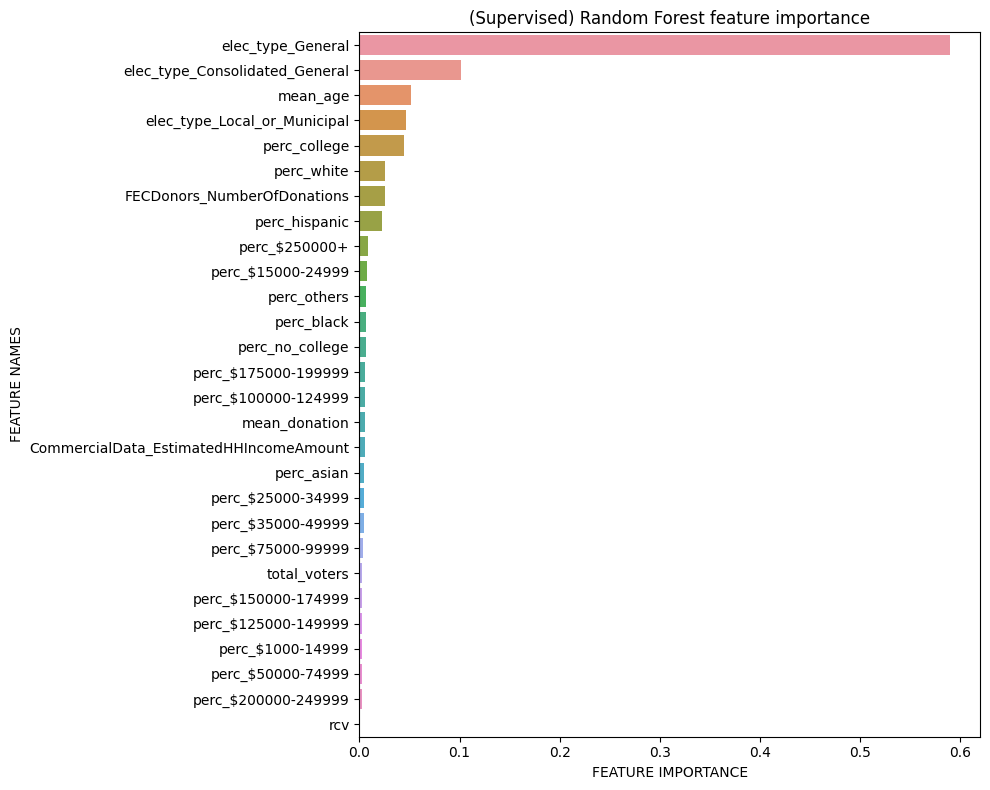

In [26]:
import seaborn as sns 
def plot_feature_importance(importance,names,fig_title, file_name):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(fig_title)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.tight_layout()
    plt.savefig(f'../data/plots/{file_name}.jpg')

plot_feature_importance(best_model.feature_importances_, X.columns,
                        fig_title = '(Supervised) Random Forest feature importance', 
                        file_name = 'RF_feature_imp_supervised_overall')


# How does feature importance differ between RCV and Non RCV?

### RCV

In [27]:
#implement random forest
rcv_df = df[df['rcv'] == 1]
rcv_target = rcv_df['turnout']
rcv_data = rcv_df.drop(columns=['turnout', 'rcv'])

rcv_rf = RandomForestRegressor(bootstrap = True, oob_score = True, random_state = 0, 
                               max_depth= None, max_features= 16, n_estimators = 100)
rcv_rf.fit(rcv_data, rcv_target)

rcv_pred = rcv_rf.predict(rcv_data)

def get_metrics_CV(model, data, target):
    mae = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)), 3)
    mse = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_squared_error', cv=10, n_jobs=-1)), 3)
    r2 = round(np.mean(cross_val_score(model, data, target, 
                                  scoring='r2', cv=10, n_jobs=-1)), 3)
    
    
    print("Cross validation Mean Absolute Error score:", mae)
    print("Cross validation Mean Squared Error score:", mse)
    print("Cross validation R-sqaured score:", r2)
    return pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])

print("RCV Cross Validation")
rf_rcv_cv = get_metrics_CV(rcv_rf, rcv_data, rcv_target)
rf_rcv_cv.columns = ['metric', 'rf_rcv_cv']
print(rf_rcv_cv)


RCV Cross Validation
Cross validation Mean Absolute Error score: 0.05
Cross validation Mean Squared Error score: 0.004
Cross validation R-sqaured score: 0.875
                metric  rf_rcv_cv
0  Mean_Absolute_Error      0.050
1   Mean_Squared_Error      0.004
2      R_squared_score      0.875


In [28]:
#generate and print ordered list of feature importance scores
rcv_sorted_features, rcv_sorted_feature_importance = ordered_feature_importance(rcv_data.columns, rcv_rf.feature_importances_, n=len(rcv_data.columns))

Feature 0 (elec_type_General) importance: 0.5709125853499473
Feature 1 (elec_type_Consolidated_General) importance: 0.22706746220341942
Feature 2 (mean_age) importance: 0.04299698642644094
Feature 3 (elec_type_Local_or_Municipal) importance: 0.025633219619189313
Feature 4 (perc_college) importance: 0.016879863901370216
Feature 5 (perc_$250000+) importance: 0.01568109596156684
Feature 6 (FECDonors_NumberOfDonations) importance: 0.015331406788878298
Feature 7 (perc_hispanic) importance: 0.009350189310685614
Feature 8 (perc_$150000-174999) importance: 0.008852383363305794
Feature 9 (perc_no_college) importance: 0.008426478750140923
Feature 10 (mean_donation) importance: 0.007475766869472262
Feature 11 (perc_$100000-124999) importance: 0.005738970587472153
Feature 12 (perc_$15000-24999) importance: 0.0048656729114621225
Feature 13 (perc_$50000-74999) importance: 0.004551853014757529
Feature 14 (perc_$200000-249999) importance: 0.004302567370575883
Feature 15 (perc_$1000-14999) importance: 

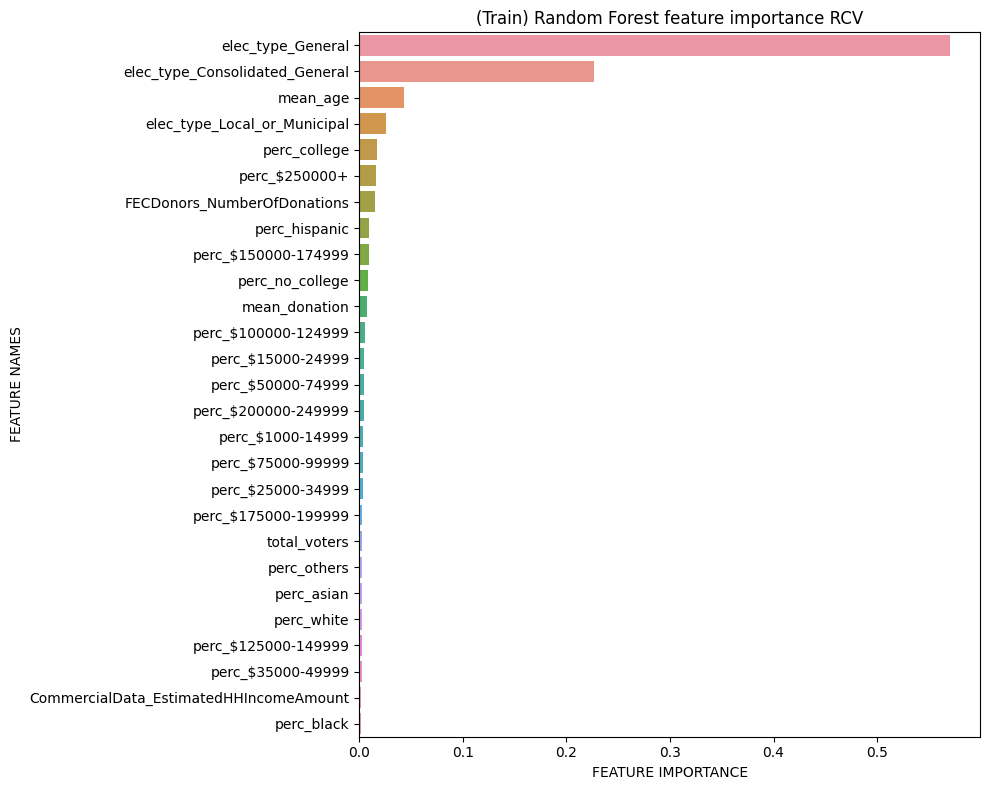

In [29]:
plot_feature_importance(rcv_rf.feature_importances_, rcv_data.columns, 
                        fig_title ='(Train) Random Forest feature importance RCV', 
                        file_name = 'RF_feature_imp_RCV')

### Non-RCV

In [30]:
#implement random forest
non_rcv_df = df[df['rcv'] == 0]
non_rcv_target = non_rcv_df['turnout']
non_rcv_data = non_rcv_df.drop(columns=['turnout', 'rcv'])

non_rcv_rf = RandomForestRegressor(bootstrap = True, random_state = 0, oob_score = True,
                                   max_depth= None, max_features= 16, n_estimators = 100)
non_rcv_rf.fit(non_rcv_data, non_rcv_target)


non_rcv_pred = non_rcv_rf.predict(non_rcv_data)

print("Non RCV Cross Validation")
rf_nonrcv_cv = get_metrics_CV(non_rcv_rf, non_rcv_data, non_rcv_target)
rf_nonrcv_cv.columns = ['metric', 'rf_nonrcv_cv']
print(rf_nonrcv_cv)


Non RCV Cross Validation
Cross validation Mean Absolute Error score: 0.047
Cross validation Mean Squared Error score: 0.004
Cross validation R-sqaured score: 0.911
                metric  rf_nonrcv_cv
0  Mean_Absolute_Error         0.047
1   Mean_Squared_Error         0.004
2      R_squared_score         0.911


In [31]:
#generate and print ordered list of feature importance scores
non_rcv_sorted_features, non_rcv_sorted_feature_importance = ordered_feature_importance(non_rcv_data.columns, non_rcv_rf.feature_importances_, n=len(non_rcv_data.columns))

Feature 0 (elec_type_General) importance: 0.5354450224712061
Feature 1 (elec_type_Consolidated_General) importance: 0.10522144006346408
Feature 2 (mean_age) importance: 0.0713773012240085
Feature 3 (elec_type_Local_or_Municipal) importance: 0.06709731324237432
Feature 4 (perc_college) importance: 0.05277482846415752
Feature 5 (FECDonors_NumberOfDonations) importance: 0.031351940566692965
Feature 6 (perc_white) importance: 0.023214237359885193
Feature 7 (perc_hispanic) importance: 0.02157166901982268
Feature 8 (perc_black) importance: 0.009379079395815676
Feature 9 (perc_others) importance: 0.007232582292521622
Feature 10 (perc_$15000-24999) importance: 0.006064600565827797
Feature 11 (perc_$100000-124999) importance: 0.0060429759460957745
Feature 12 (perc_$250000+) importance: 0.005845007244231763
Feature 13 (perc_$35000-49999) importance: 0.005808612945195258
Feature 14 (CommercialData_EstimatedHHIncomeAmount) importance: 0.0049170593375354055
Feature 15 (perc_$75000-99999) importance

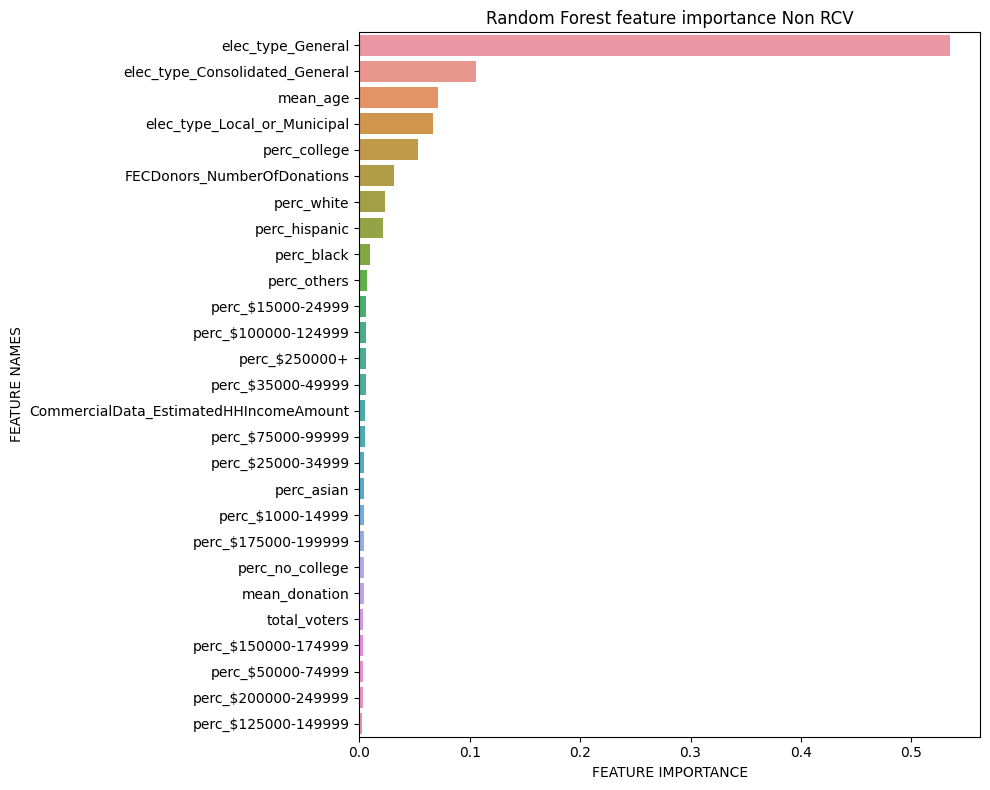

In [32]:
plot_feature_importance(non_rcv_rf.feature_importances_, non_rcv_data.columns, 
                        fig_title = 'Random Forest feature importance Non RCV', 
                        file_name = 'RF_feature_imp_Non_RCV')


### RCV vs. Non-RCV

In [33]:
#Match ranking of feature importance
rcv_v_nonrcv_df = pd.DataFrame({'rcv_feature': rcv_sorted_features, 'rcv_importance': rcv_sorted_feature_importance,
                  'non_rcv_feature': non_rcv_sorted_features, 'non_rcv_importance': non_rcv_sorted_feature_importance})
rcv_v_nonrcv_df

,rcv_feature,rcv_importance,non_rcv_feature,non_rcv_importance
0,elec_type_General,0.570913,elec_type_General,0.535445
1,elec_type_Consolidated_General,0.227067,elec_type_Consolidated_General,0.105221
2,mean_age,0.042997,mean_age,0.071377
3,elec_type_Local_or_Municipal,0.025633,elec_type_Local_or_Municipal,0.067097
4,perc_college,0.016880,perc_college,0.052775
5,perc_$250000+,0.015681,FECDonors_NumberOfDonations,0.031352
6,FECDonors_NumberOfDonations,0.015331,perc_white,0.023214
7,perc_hispanic,0.009350,perc_hispanic,0.021572
8,perc_$150000-174999,0.008852,perc_black,0.009379
9,perc_no_college,0.008426,perc_others,0.007233


In [34]:
#Match features
nonrcv_df = pd.DataFrame({'feature': non_rcv_sorted_features, 'importance_nonrcv': non_rcv_sorted_feature_importance})
rcv_df = pd.DataFrame({'feature': rcv_sorted_features, 'importance_rcv': rcv_sorted_feature_importance})
rcv_v_nonrcv_df = nonrcv_df.merge(rcv_df, on = "feature")
rcv_v_nonrcv_df.head()

,feature,importance_nonrcv,importance_rcv
0,elec_type_General,0.535445,0.570913
1,elec_type_Consolidated_General,0.105221,0.227067
2,mean_age,0.071377,0.042997
3,elec_type_Local_or_Municipal,0.067097,0.025633
4,perc_college,0.052775,0.016880


In [35]:
rcv_v_nonrcv_df = pd.melt(rcv_v_nonrcv_df, id_vars=['feature'], value_vars=['importance_nonrcv','importance_rcv'])
rcv_v_nonrcv_df.head()

,feature,variable,value
0,elec_type_General,importance_nonrcv,0.535445
1,elec_type_Consolidated_General,importance_nonrcv,0.105221
2,mean_age,importance_nonrcv,0.071377
3,elec_type_Local_or_Municipal,importance_nonrcv,0.067097
4,perc_college,importance_nonrcv,0.052775


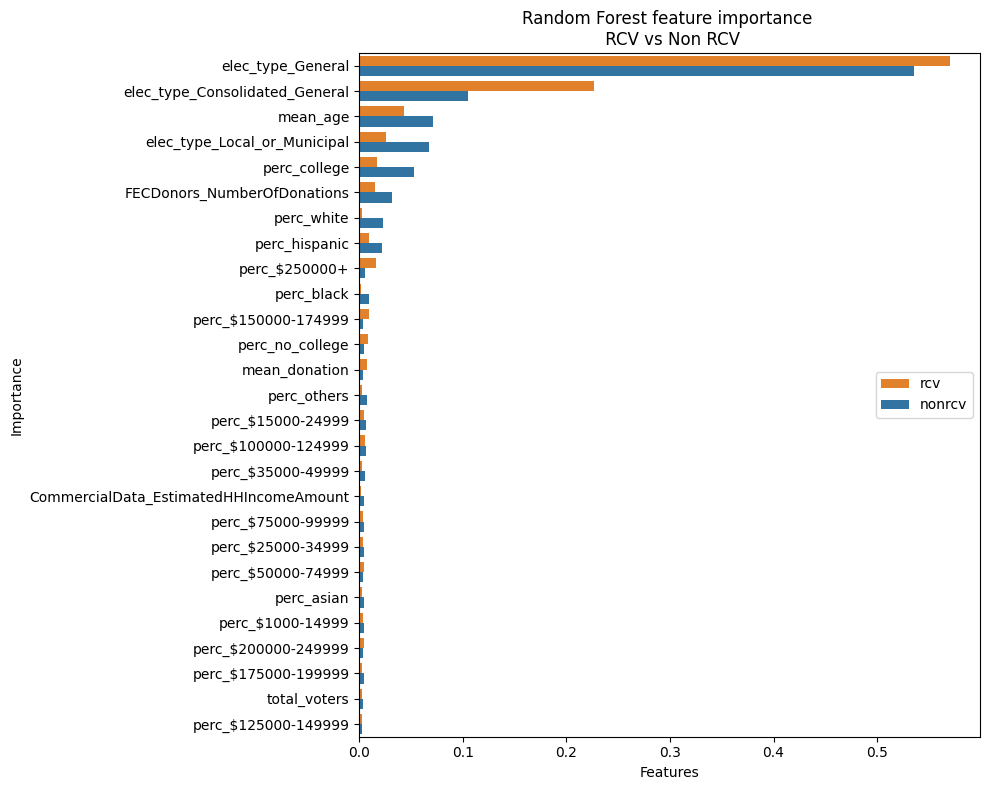

In [36]:
# Plotting
import seaborn as sns 

#Create arrays from feature importance and feature names
variable = np.array(rcv_v_nonrcv_df['variable'])
value = np.array(rcv_v_nonrcv_df['value'])
feature_names = np.array(rcv_v_nonrcv_df['feature'])

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'variable':variable,'value':value}
fi_df = pd.DataFrame(data)
fi_df = fi_df.replace({'importance_nonrcv': 'nonrcv', 'importance_rcv': 'rcv'})

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['value'], ascending=False,inplace=True)

plt.figure(figsize=(10,8))
palette ={"nonrcv": "C0", "rcv": "C1"}

sns.barplot(x=fi_df['value'], y=fi_df['feature_names'], hue = fi_df['variable'], palette=palette)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest feature importance \n RCV vs Non RCV')
plt.legend(loc='center right')
plt.tight_layout()
plt.savefig(f'../data/plots/RF_feature_imp_RCV_vs_Non_RCV.jpg')


# Linear Regression

In [37]:
# importing modules and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [38]:
#cat_cols = ['rcv', 'elec_type_Consolidated_General', 'elec_type_General', 'elec_type_Local_or_Municipal']
num_cols = [c for c in X_train.columns if c not in cat_cols]

ct = ColumnTransformer([
        ('somename', StandardScaler(), num_cols)
    ], remainder='passthrough')

ct.fit(X_train)
scaled_X_train = pd.DataFrame(ct.transform(X_train), columns = X_train.columns)

scaled_X_test = pd.DataFrame(ct.transform(X_test), columns = X_test.columns)
scaled_X_train.head()


,perc_asian,perc_black,perc_hispanic,perc_others,perc_white,FECDonors_NumberOfDonations,mean_donation,perc_$1000-14999,perc_$100000-124999,perc_$125000-149999,...,perc_$75000-99999,CommercialData_EstimatedHHIncomeAmount,perc_college,perc_no_college,mean_age,total_voters,rcv,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal
0,-0.450437,-0.280268,0.162081,-0.562825,0.085107,-0.340171,-0.839904,-0.413866,-0.791032,-0.509210,...,0.420304,-0.843991,-0.960875,2.507093,0.193901,-0.407648,2.326595,1.473785,-1.182529,-0.336463
1,-0.622602,-0.287377,2.913912,-0.821092,-2.341971,-0.239149,-0.846691,3.261603,-1.392434,-1.416111,...,-1.792543,-1.843672,-1.754021,0.669420,0.408826,-0.381009,-0.429813,-0.678525,0.845645,-0.336463
2,-0.621203,-0.300823,-0.234908,-0.606327,0.494155,-0.177796,-0.575783,0.390264,-0.818138,-0.586430,...,0.466406,-0.691713,-0.241889,0.963262,0.697810,-0.233377,-0.429813,-0.678525,0.845645,-0.336463
3,4.054034,0.194175,-0.552841,3.835888,-0.896111,0.482613,5.758860,-1.126385,-1.334969,-1.315438,...,-2.207238,3.688626,1.837091,-1.970615,0.315820,-0.090504,-0.429813,-0.678525,0.845645,-0.336463
4,0.153795,0.341295,-0.437808,0.423350,0.233832,-0.242381,-0.878541,0.156979,0.393019,-0.429418,...,1.305771,-0.503888,0.287635,0.221957,-0.868262,-0.291725,-0.429813,-0.678525,0.845645,-0.336463


In [39]:
#implement random forest
linreg = LinearRegression()

linreg.fit(scaled_X_train, y_train)
train_pred = linreg.predict(scaled_X_train)
test_pred = linreg.predict(scaled_X_test)


print("Train")
linreg_overall_train = get_metrics(y_train, train_pred)
linreg_overall_train.columns = ['metric', 'linreg_overall_train']
print(linreg_overall_train)

print("Test")
linreg_overall_test = get_metrics(y_test, test_pred)
linreg_overall_test.columns = ['metric', 'linreg_overall_test']
print(linreg_overall_test)

Train
Mean Absolute Error: 0.048
Mean Squared Error: 0.004
R-squared scores: 0.904
                metric  linreg_overall_train
0  Mean_Absolute_Error              0.048038
1   Mean_Squared_Error              0.003854
2      R_squared_score              0.904500
Test
Mean Absolute Error: 0.057
Mean Squared Error: 0.005
R-squared scores: 0.865
                metric  linreg_overall_test
0  Mean_Absolute_Error             0.057082
1   Mean_Squared_Error             0.005174
2      R_squared_score             0.865086


In [40]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(linreg.coef_))], axis = 1)
coefficients.columns = ['feature', 'linreg_coefficient']

coefficients.sort_values('linreg_coefficient', ascending = False)

,feature,linreg_coefficient
19,CommercialData_EstimatedHHIncomeAmount,3.904648e-01
26,elec_type_General,1.089001e-01
16,perc_$35000-49999,6.359100e-02
17,perc_$50000-74999,6.137848e-02
7,perc_$1000-14999,5.374908e-02
10,perc_$15000-24999,3.543091e-02
22,mean_age,2.337837e-02
18,perc_$75000-99999,1.679611e-02
14,perc_$25000-34999,1.355934e-02
20,perc_college,1.062202e-02


# Compare Random Forest and Linear Regression

In [41]:
pd.merge(linreg_overall_train, rf_overall_train, on = "metric")


,metric,linreg_overall_train,rf_overall_train
0,Mean_Absolute_Error,0.048038,0.016877
1,Mean_Squared_Error,0.003854,0.000466
2,R_squared_score,0.904500,0.988452


In [42]:
pd.merge(linreg_overall_test, rf_overall_test, on = "metric")


,metric,linreg_overall_test,rf_overall_test
0,Mean_Absolute_Error,0.057082,0.050705
1,Mean_Squared_Error,0.005174,0.004001
2,R_squared_score,0.865086,0.895656


# P-value from Linear Regression Model

In [43]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                turnout   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     97.65
Date:                Mon, 21 Nov 2022   Prob (F-statistic):          7.58e-121
Time:                        15:19:15   Log-Likelihood:                 401.33
No. Observations:                 295   AIC:                            -748.7
Df Residuals:                     268   BIC:                            -649.1
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [ ]:

# # # define standard scaler
# # scaler = StandardScaler()

# # cat_X_train = X_train[cat_cols]
# # num_X_train = X_train[num_cols]
# # print(num_X_train.shape)

# # num_X_test = X_test[num_cols]
# # cat_X_test = X_test[cat_cols]
# # print(num_X_test.shape)
# # num_X_train.head()

# # # transform data
# # scaler.fit(num_X_train)
# # scaled_X_train = pd.DataFrame(scaler.transform(num_X_train), columns = num_cols)
# # print(scaled_X_train.shape)
# # scaled_X_test = pd.DataFrame(scaler.transform(num_X_test), columns = num_cols)
# # print(scaled_X_test.shape)

# # comb_X_train = pd.merge(scaled_X_train, cat_X_train, left_index=True, right_index=True)
# # print(comb_X_train.shape)
# # comb_X_train = comb_X_train.sort_index(ascending=True)

# # comb_X_train.head()

# # comb_X_test = pd.merge(scaled_X_test, cat_X_test, left_index=True, right_index=True)
# # print(comb_X_test.shape)
# # comb_X_test = comb_X_test.sort_index(ascending=True)
# # comb_X_test.head()
# linreg.fit(comb_X_train, y_train)
# train_pred = linreg.predict(comb_X_train)
# test_pred = linreg.predict(comb_X_test)


# print("Train")
# linreg_overall_train = get_metrics(y_train, train_pred)
# linreg_overall_train.columns = ['metric', 'linreg_overall_train']
# print(linreg_overall_train)

# print("Test")
# linreg_overall_test = get_metrics(y_test, test_pred)
# linreg_overall_test.columns = ['metric', 'linreg_overall_test']
# print(linreg_overall_test)